In [1]:
import xarray as xr
from floater import rclv
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

/Users/rpa/anaconda/envs/geo_scipy/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
ds = xr.open_dataset('lavd_prob_reg.nc')
ds

<xarray.Dataset>
Dimensions:    (x0: 450, y0: 500)
Coordinates:
  * y0         (y0) float32 -40.99 -40.97 -40.95 -40.93 -40.91 -40.89 -40.87 ...
  * x0         (x0) float32 1.01 1.03 1.05 1.07 1.09 1.11 1.13 1.15 1.17 ...
Data variables:
    lavd_15_h  (y0, x0) float32 ...
    lavd_15_d  (y0, x0) float32 ...
    lavd_15_w  (y0, x0) float32 ...
    lavd_30_h  (y0, x0) float32 ...
    lavd_30_d  (y0, x0) float32 ...
    lavd_30_w  (y0, x0) float32 ...
    lavd_60_h  (y0, x0) float32 ...
    lavd_60_d  (y0, x0) float32 ...
    lavd_60_w  (y0, x0) float32 ...

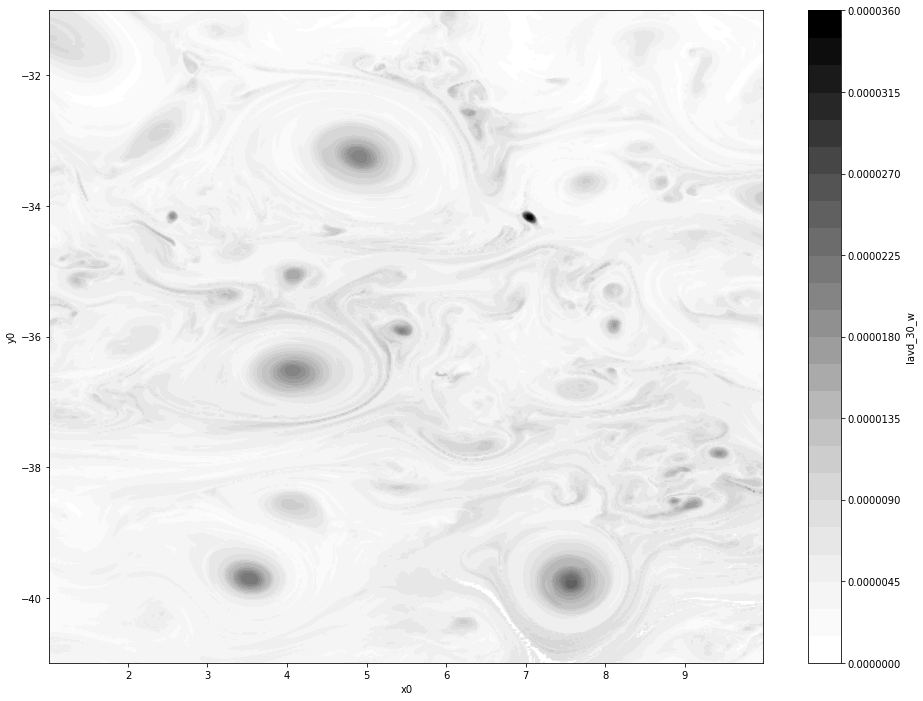

In [3]:
data = ds.lavd_30_w
plt.figure(figsize=(16,12))
data.plot.contourf(levels=30, cmap='Greys')

In [4]:
from skimage.feature import peak_local_max

In [5]:
raw = data.data
plm = peak_local_max(raw, min_distance=100)

In [6]:
len(plm)

3

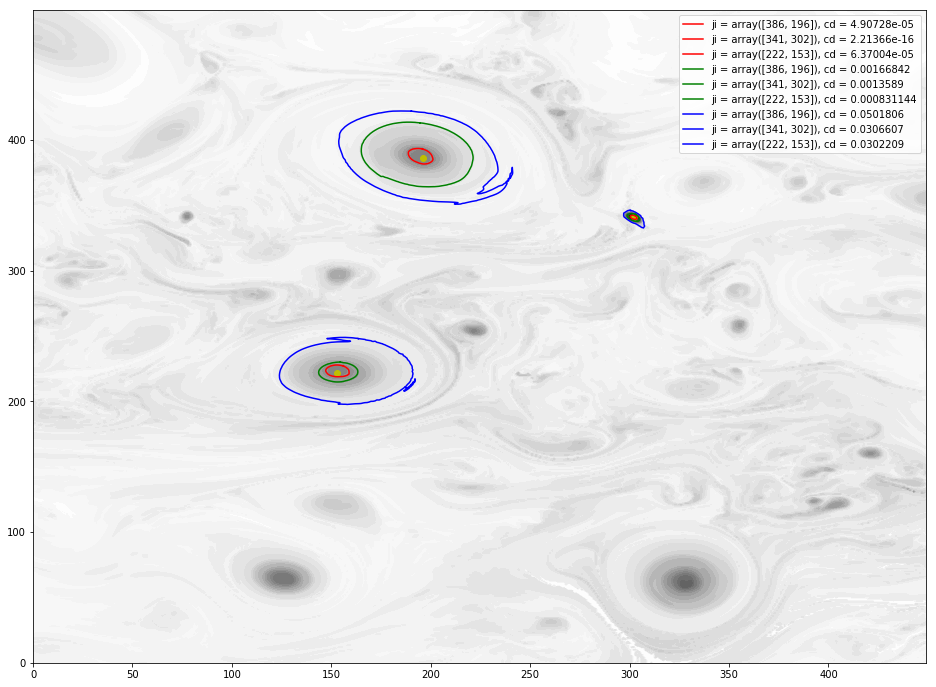

In [7]:
plt.figure(figsize=(16,12))
plt.contourf(raw, 30)
plt.set_cmap('Greys')
plt.plot(plm[:, 1], plm[:, 0], 'yo')
for cd, color in zip([0.001, 0.01, 0.1], ['r', 'g', 'b']):
    for ji in plm:
        con, area, cd = rclv.convex_contour_around_maximum(raw, ji, init_contour_step_frac=0.1, convex_def=cd)
        plt.plot(con[:, 1], con[:, 0], color=color, label='ji = %r, cd = %g' % (ji, cd))
plt.legend()

In [44]:
md = 40
cd = 0.01
ma = 30.
step_frac = 0.1

res = list(rclv.find_convex_contours(raw, init_contour_step_frac=step_frac, 
                                     convex_def=cd, min_distance=md, min_area=ma, progress=True))
len(res)

100%|██████████| 18/18 [00:00<00:00, 76.60it/s]


8

In [45]:
def plot_contours(res):
    plm = peak_local_max(raw, min_distance=md)
    plt.figure(figsize=(16,12))
    plt.contourf(raw, 30)
    plt.set_cmap('Greys')
    plt.plot(plm[:, 1], plm[:, 0], 'co')
    for (ji, con, area, cd) in res:
        plt.plot(ji[1], ji[0], 'mo')
        plt.plot(con[:, 1], con[:, 0], 'm-')

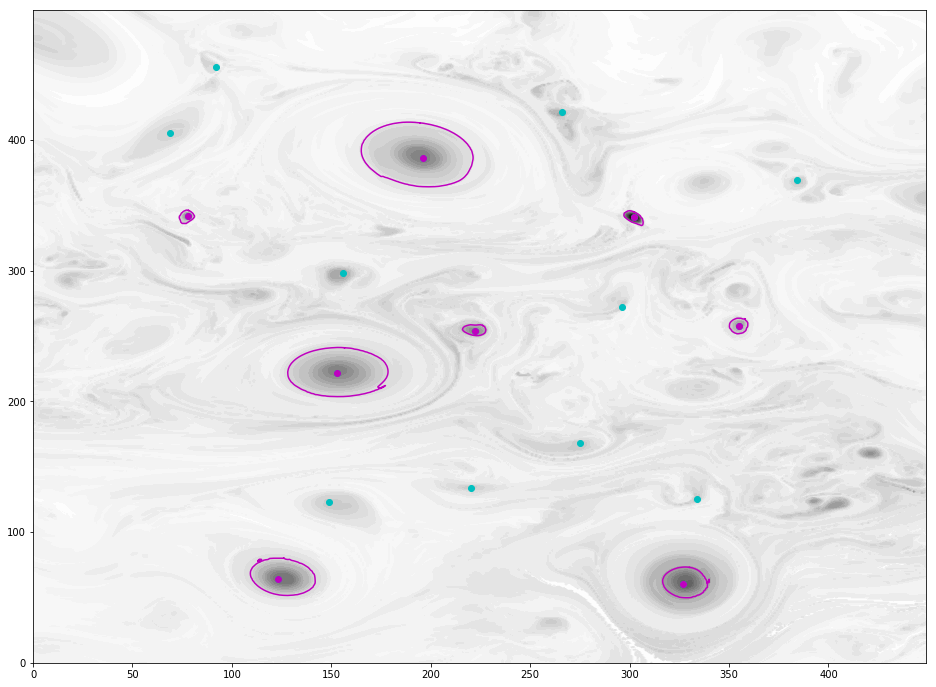

In [46]:
plot_contours(res)

In [43]:
res2 = list(rclv.find_convex_contours(raw, init_contour_step_frac=0.2, 
                                      convex_def=cd, min_distance=md, min_area=ma, progress=True))
print(len(res2))
plot_contours(res2)

  0%|          | 0/18 [00:00<?, ?it/s]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

100%|██████████| 40/40 [00:01<00:00, 27.52it/s]


9


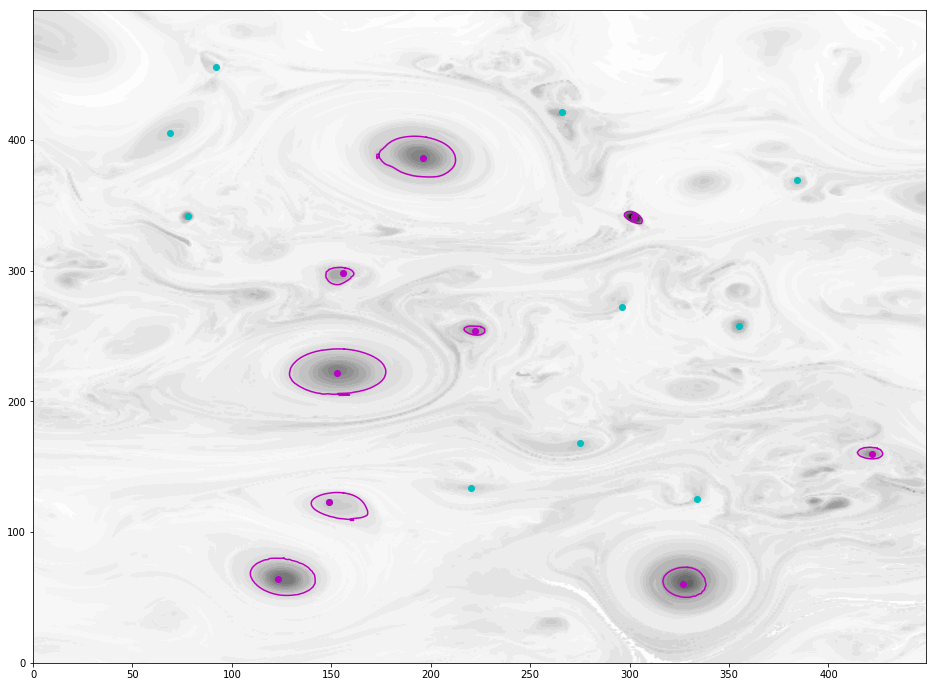

In [58]:
res3 = list(rclv.find_convex_contours(raw, init_contour_step_frac=0.25, 
                                      convex_def=0.005, min_distance=25, min_area=50, progress=True))
print(len(res3))
plot_contours(res3)

In [14]:
ji = (123, 149)

In [59]:
1000 * 10000

10000000

In [15]:
raw[ji]

1.1231104e-05

In [37]:
def cd_vs_contour(data, ji, frac_levels=np.arange(0.01, 0.71, 0.01)):
    area_vs_contour = np.full((len(frac_levels), 3), np.nan)
    for n, frac in enumerate(frac_levels):
        level = frac * data[ji]
        try:
            con, region_data, _, _ = rclv.find_contour_around_maximum(raw, ji, level)
            area_vs_contour[n] = rclv.contour_area(con)
        except ValueError:
            break
        #plt.figure()
        #plt.pcolormesh(region_data)
        #plt.plot(con[:, 1], con[:, 0], 'm-')
    region_area, hull_area, cd = np.array(area_vs_contour).transpose()
    return frac_levels, cd

In [38]:
plm[0]

array([421, 266])

In [39]:
len(plm)

14

(1e-05, 10)

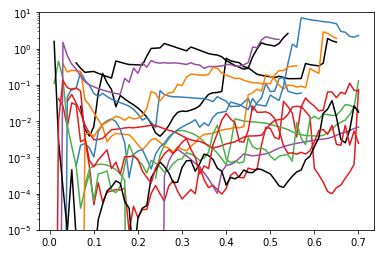

In [40]:
plm = peak_local_max(raw, min_distance=50)
for ji in plm:
    this_cd = cd_vs_contour(raw, tuple(ji))
    plt.semilogy(*this_cd)
plt.ylim([1e-5,10])

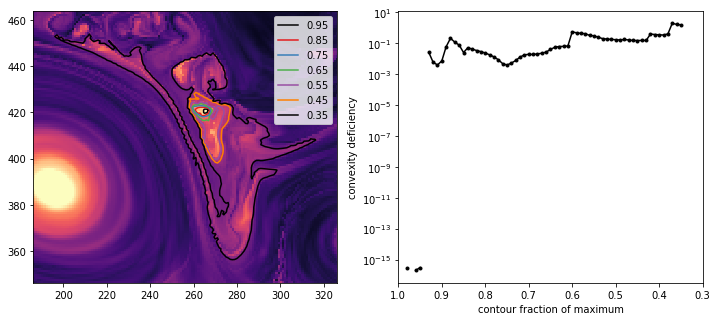

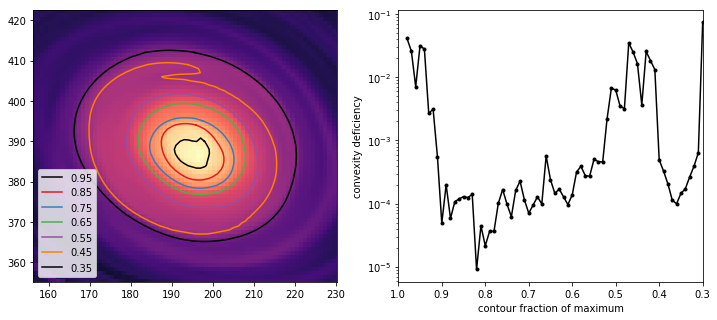

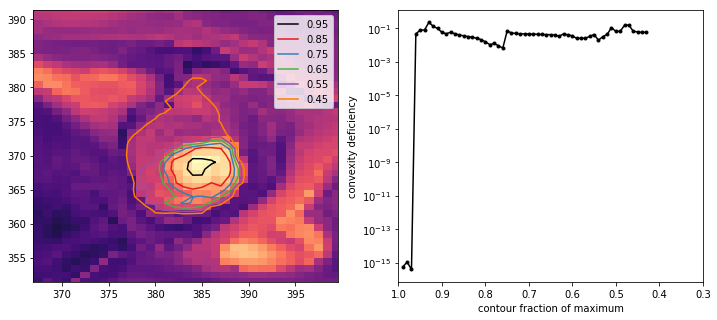

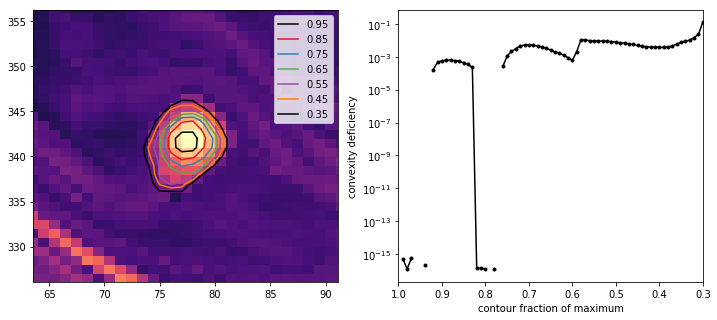

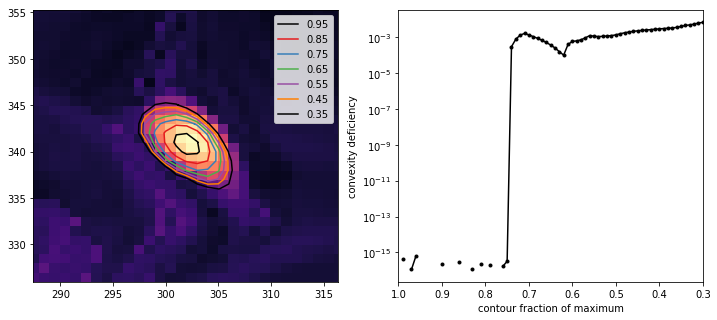

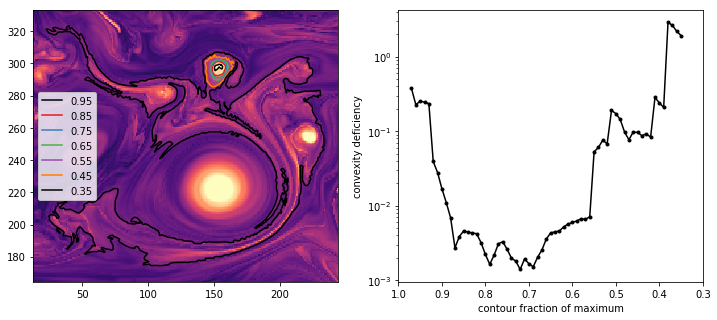

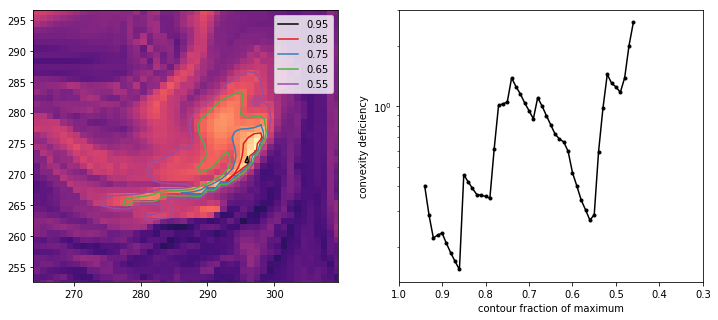

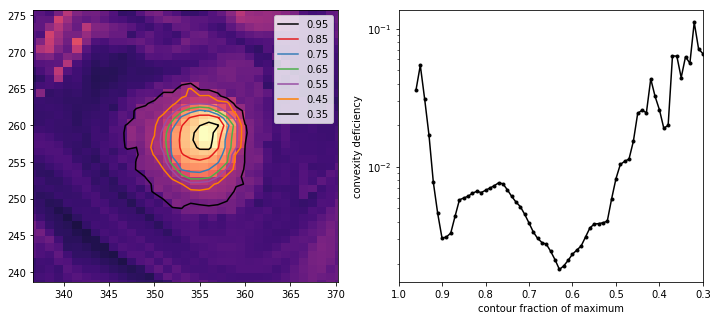

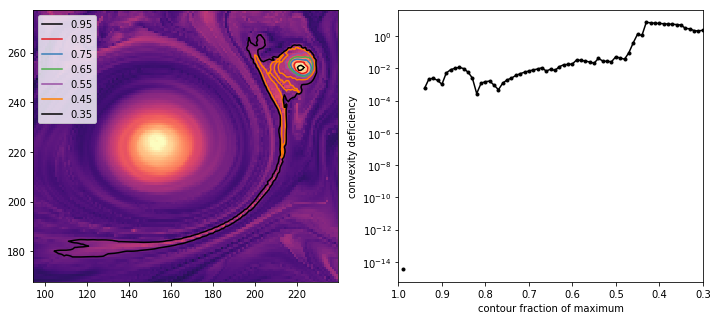

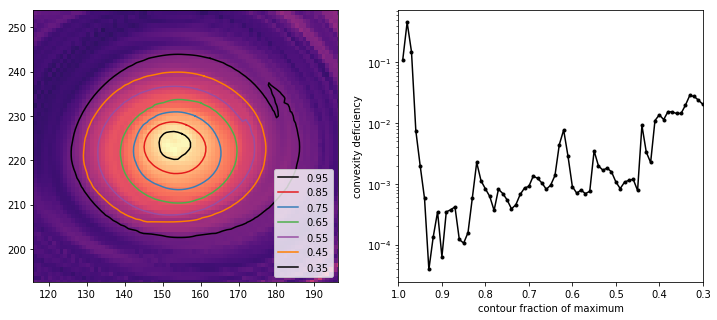

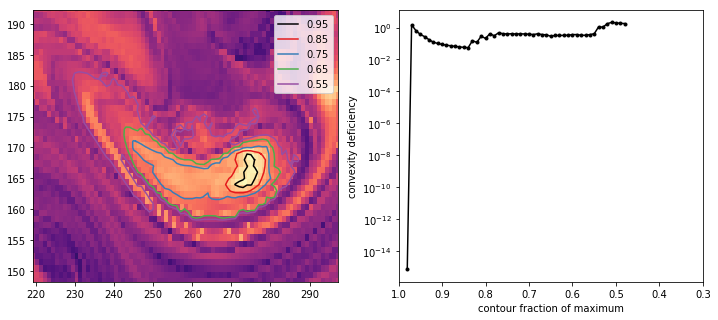

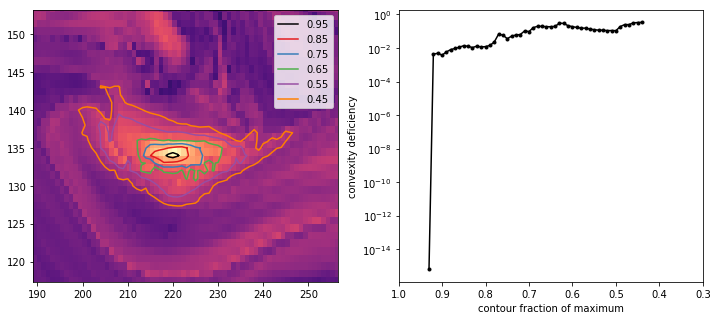

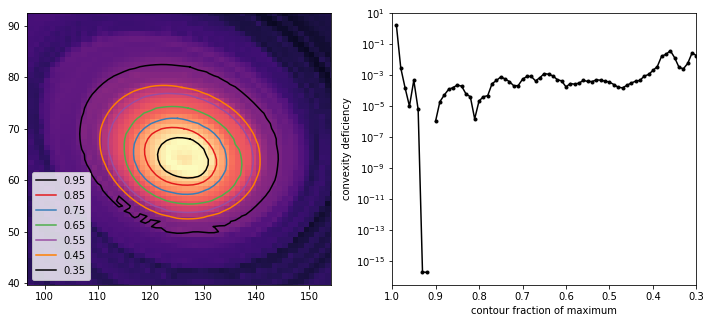

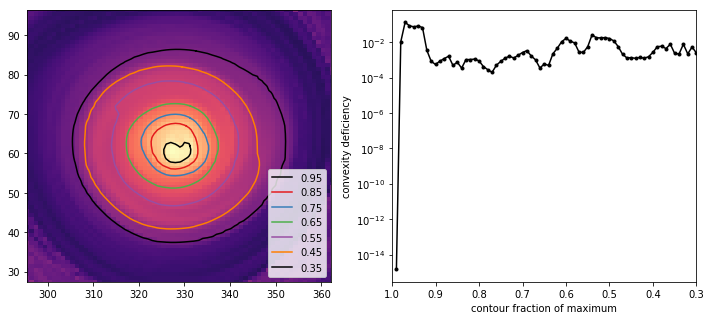

In [42]:
#ji = (123, 149)
for ji in plm:
    ji = tuple(ji)
    frac_levels, cd = cd_vs_contour(raw, ji)

    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,5))
    pc = ax0.pcolormesh(raw, cmap='magma')
    for frac in np.arange(0.05,0.7,0.1):
        lev = frac * raw[ji]
        try:
            contour, region_data, border_j, border_i = rclv.find_contour_around_maximum(raw, ji, lev)
            contour[:, 0] += (ji[0]-border_j[0])
            contour[:, 1] += (ji[1]-border_i[0])
            ax0.plot(contour[:, 1], contour[:, 0], label='%3.2f' % (1-frac))
        except ValueError:
            break
    ax0.set_ylim([contour[:,0].min() - 10, contour[:,0].max() + 10])
    ax0.set_xlim([contour[:,1].min() - 10, contour[:,1].max() + 10])
    ax0.legend()
    pc.set_clim([0, raw[ji]])


    ax1.semilogy(1-frac_levels, cd, '.-')
    ax1.set_xlim([1, 0.3])
    ax1.set_xlabel('contour fraction of maximum')
    ax1.set_ylabel('convexity deficiency')


In [85]:
logging.basicConfig(level=logging.INFO)

In [72]:
import logging

INFO:floater.rclv:convex_contour_around_maximum (123, 149) max_value 1.12311e-05
DEBUG:floater.rclv:init_contour_step_frac 0.3
DEBUG:floater.rclv:init_contour_step_size 3.36933e-06
DEBUG:floater.rclv:iter 0, cd inf
DEBUG:floater.rclv:current lims: (0.00000000000000000000, 0.00000673866215947783)
DEBUG:floater.rclv:contouring level: 0.00000336933107973891 border: (5, 5)(5, 5)
DEBUG:floater.rclv:get_local_region (123, 149)(5, 5)(5, 5)
DEBUG:floater.rclv:get_local_region (123, 149)(10, 5)(5, 10)
DEBUG:floater.rclv:get_local_region (123, 149)(15, 10)(10, 15)
DEBUG:floater.rclv:get_local_region (123, 149)(20, 15)(15, 20)
DEBUG:floater.rclv:get_local_region (123, 149)(25, 20)(20, 25)
DEBUG:floater.rclv:region_area:  387.6, hull_area:  387.9, convex_def:  7.20175e-04
DEBUG:floater.rclv:still searching for upper_lim, new lims (3.36933e-06, 1.0108e-05)
DEBUG:floater.rclv:iter 1, cd 0.000720175
DEBUG:floater.rclv:current lims: (0.00000336933107973891, 0.00001010799323921674)
DEBUG:floater.rclv:c

DEBUG:floater.rclv:contouring level: 0.00000505399661960837 border: (30, 35)(35, 30)
DEBUG:floater.rclv:get_local_region (123, 149)(35, 30)(30, 35)
DEBUG:floater.rclv:region_area:  666.4, hull_area:  671.1, convex_def:  6.98859e-03
DEBUG:floater.rclv:iter 4, cd 0.00698859
DEBUG:floater.rclv:current lims: (0.00000505399661960837, 0.00000673866215947783)
DEBUG:floater.rclv:contouring level: 0.00000589632938954310 border: (30, 35)(35, 30)
DEBUG:floater.rclv:get_local_region (123, 149)(35, 30)(30, 35)
DEBUG:floater.rclv:region_area:  821.7, hull_area:  832.1, convex_def:  1.26771e-02
DEBUG:floater.rclv:iter 5, cd 0.0126771
DEBUG:floater.rclv:current lims: (0.00000589632938954310, 0.00000673866215947783)
DEBUG:floater.rclv:contouring level: 0.00000631749577451046 border: (30, 35)(35, 30)
DEBUG:floater.rclv:get_local_region (123, 149)(35, 30)(30, 35)
DEBUG:floater.rclv:region_area:  889.9, hull_area:  906.7, convex_def:  1.88986e-02
DEBUG:floater.rclv:iter 6, cd 0.0188986
DEBUG:floater.rclv:

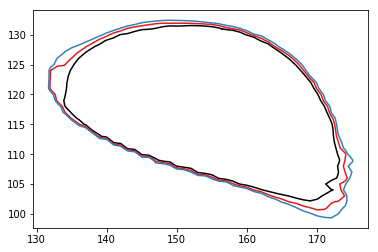

In [88]:
for cd in [0.01, 0.015, 0.02]:
    con, area, cd = rclv.convex_contour_around_maximum(raw, ji, convex_def=cd, init_contour_step_frac=0.3)
    plt.plot(con[:, 1], con[:, 0])

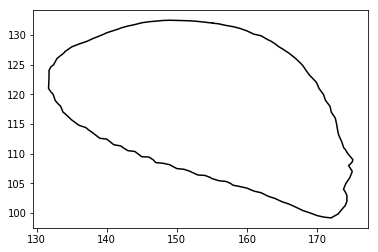

In [80]:
plt.plot(con[:, 1], con[:, 0])

In [66]:
del d['b']

KeyError: 'b'

In [68]:
c = d

In [69]:
c['fat'] = 3

In [70]:
d

{'a': 1, 'fat': 3}

In [71]:
c = d.copy()

In [72]:
c

{'a': 1, 'fat': 3}

In [73]:
c['foo'] = 2

In [74]:
d

{'a': 1, 'fat': 3}